# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Pau Argelaguet Franquelo"
student2 = "Natalie Bolon Brun"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(284216 + 285155)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [4]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('data/train_32x32.mat')
data_test = scipy.io.loadmat('data/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [5]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

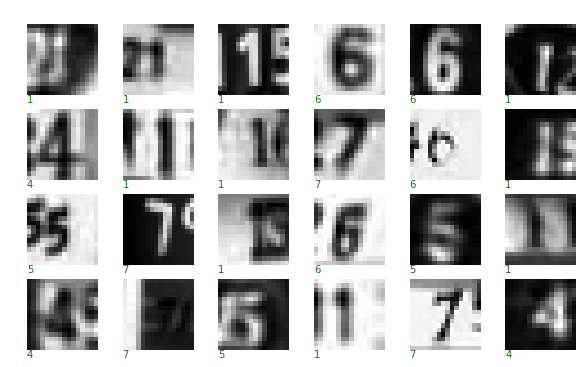

In [6]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [ ]:
ex1_model = Sequential([
    Dense(5, input_shape=(256,), activation='softmax'),
])

ex1_model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
ex1_history = ex1_model.fit(x_train, y_train, epochs=300, validation_data=(x_test,y_test), batch_size=128, verbose=1)

In [ ]:
ex1_model.summary()
plot_history(ex1_history, "No hidden layer")
plt.show()

In [ ]:
score = ex1_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
yhat_test = ex1_model.predict_on_batch(x_test)
error = np.linalg.norm(((yhat_test.round()) - y_test),axis=1)
error_indices = np.nonzero(error)[0]

In [ ]:
plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)
plt.show()

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [ ]:
ex2_model_sgd = Sequential([
    Dense(64, input_shape=(256,), activation='relu'),
    Dense(5, activation='softmax'),
])

ex2_model_sgd.summary()

In [ ]:
lrates = [0.01, 0.05, 0.1, 0.5, 1, 2]
histories = []
for lrate in lrates:
    ex2_model_sgd.compile(optimizer=SGD(lr=lrate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    histories.append(
        ex2_model_sgd.fit(x_train, y_train, epochs=50, validation_data=(x_test,y_test), batch_size=128, verbose=1))

In [ ]:
print("LR loss acc val_loss val_acc")
for lr, h in zip(lrates, histories):
    print(lr, h.history.get('loss')[-1], h.history.get('acc')[-1], 
          h.history.get('val_loss')[-1], h.history.get('val_acc')[-1])

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) If the learning rate is too large, the solucion may oscillate around a value and never achieve a minimum. It may even lead to increasing error during the training period obtening very poor results.

B) If the learning rate is too small, the improvement per epoch may be too small too and so, the number of epochs needed to achieve a reasonable results may be extremly large. 

In [ ]:
ex2_model_ada = Sequential([
    Dense(64, input_shape=(256,), activation='relu'),
    Dense(5, activation='softmax'),
])

ex2_model_ada.summary()

In [ ]:
ex2_model_ada.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

adam_history = ex2_model_ada.fit(
    x_train, y_train, epochs=50, validation_data=(x_test,y_test), batch_size=128, verbose=1)

In [ ]:
# histories[2] (lr=0.1) gives the best results
plot_history(histories[4], "One hidden layer - SGD")
plot_history(adam_history, "One hidden layer - Adam")
plt.show()

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [ ]:
ex3_model = Sequential([
    Dense(64, input_shape=(256,), activation="relu"),
    Dense(5, activation="softmax"),
])

ex3_model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

ex3_history = ex3_model.fit(
    x_train, y_train, epochs=500, validation_data=(x_test,y_test), batch_size=128, verbose=1)

In [ ]:
plot_history(ex3_history, "Adam overfitting")
plt.show()

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: 

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [ ]:
hidden_n = [10, 50, 100, 200, 300, 400, 500, 1000]

accuracy = {}
losses = {}

for n in hidden_n:
    print("Number of hidden units:", params)
    accuracy[params] = []
    losses[params] = []
    for n in range(5):
        print("Iteration number", n)
        model = Sequential([
            Dense(params, input_shape=(256,), activation='relu'),
            Dense(5, activation='softmax'),
        ])

        model.compile(optimizer=SGD(lr=0.1),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
        h = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=200,  batch_size=128, verbose=0)
        accuracy[params].append(h.history.get('val_acc')[-1]) 
        losses[params].append(h.history.get('val_loss')[-1])

In [ ]:
fig1, axes1 = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=False)
fig2, axes2 = plt.subplots(nrows=3, ncols=4, figsize=(20, 15), sharey=True)
fs = 12
for n in range(len(hidden_n)):
    row = int(n/4)
    col = n%4
    data_loss = losses[hidden_n[n]]
    data_acc = accuracy[hidden_n[n]]
    
    axes1[row, col].boxplot(data_loss, manage_xticks=True)
    axes1[row, col].set_title('LOSS -- Number of hidden units:{}'.format(hidden_n[n]), fontsize=fs)
    
    axes2[row, col].boxplot(data_acc, manage_xticks=True)
    axes2[row, col].set_title('ACCURACY -- Number of hidden units:{}'.format(hidden_n[n]), fontsize=fs)
    
plt.show()

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

In [ ]:
models = []
nh_2 = 77
nh_3 = 66
nh_4 = 59

models.append(Sequential([
    Dense(100, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(5, activation='softmax')
]))

models.append(Sequential([
    Dense(nh_2, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_2, activation='relu'),
    Dense(5, activation='softmax')
]))

models.append(Sequential([
    Dense(nh_3, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_3, activation='relu'),
    Dense(nh_3, activation='relu'),
    Dense(5, activation='softmax')
]))

models.append(Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform',
                bias_initializer='random_uniform'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(5, activation='softmax')
]))

for model in models:
    model.summary()

In [ ]:
accuracy = {}
losses = {}
histories = {}

for i, model in enumerate(models):
    print("Model", i)
    accuracy[model] = []
    losses[model] = []
    histories[model] = []
    for n in range(5):
        print("Iteration number {}".format(n))
        model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
        
        h = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=300,  batch_size=128, verbose=0)
        print('Test accuracy: {}'.format(h.history.get('val_acc')[-1]))
        accuracy[model].append(h.history.get('val_acc')[-1]) 
        print('Test loss: {}'.format(h.history.get('val_loss')[-1]))
        losses[model].append(h.history.get('val_loss')[-1])
        histories[model].append(h)

In [ ]:
fig1, axes1 = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), sharey=True)
fig2, axes2 = plt.subplots(nrows=1, ncols=4, figsize=(20, 6), sharey=True)
fs = 12

for n in range(len(models)):
    row = 0
    col = n%4

    data_loss = losses[models[n]]
    data_acc = accuracy[models[n]]
    
    axes1[col].boxplot(data_loss, manage_xticks=True)
    axes1[col].set_title('LOSS -- Hidden layers:{}'.format(n), fontsize=fs)
    
    axes2[col].boxplot(data_acc, manage_xticks=True)
    axes2[col].set_title('ACCURACY -- Hidden layers:{}'.format(n), fontsize=fs)
    
plt.show()

In [ ]:
plot_history(histories[0][0],'1 layer 100 units')
plot_history(histories[1][0],'2 layers 77 units')
plot_history(histories[2][0],'3 layers 66 units')
plot_history(histories[3][0],'4 layers 59 units')

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

In [8]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform',
          kernel_regularizer=regularizers.l2(0.0005),
          bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h1 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h1.history.get('acc')[-1])
print("Val Accuracy", h1.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 1s 26us/step - loss: 1.2971 - acc: 0.5063 - val_loss: 1.0730 - val_acc: 0.6076
Epoch 2/500
39523/39523 [==============================] - 2s 38us/step - loss: 0.9455 - acc: 0.6949 - val_loss: 0.9743 - val_acc: 0.6598
Epoch 3/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.8039 - acc: 0.7511 - val_loss: 0.7978 - val_acc: 0.7375
Epoch 4/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.7265 - acc: 0.7778 - val_loss: 0.7651 - val_acc: 0.7579
Epoch 5/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.6786 - acc: 0.7951 - val_loss: 0.7041 - val_acc: 0.7785
Epoch 6/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.6444 - acc: 0.8048 - val_loss: 0.7216 - val_acc: 0.7737
Epoch 7/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.6166 - acc: 0.8128 - val_loss: 0.6634 - 

39523/39523 [==============================] - 1s 25us/step - loss: 0.3342 - acc: 0.9029 - val_loss: 0.4785 - val_acc: 0.8797
Epoch 60/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.3355 - acc: 0.9023 - val_loss: 0.5317 - val_acc: 0.8586
Epoch 61/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.3332 - acc: 0.9031 - val_loss: 0.5942 - val_acc: 0.8392
Epoch 62/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.3324 - acc: 0.9036 - val_loss: 0.5215 - val_acc: 0.8654
Epoch 63/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.3288 - acc: 0.9057 - val_loss: 0.5628 - val_acc: 0.8514
Epoch 64/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.3355 - acc: 0.9023 - val_loss: 0.5135 - val_acc: 0.8676
Epoch 65/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.3337 - acc: 0.9022 - val_loss: 0.5636 - val_acc: 0.8478
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2880 - acc: 0.9175 - val_loss: 0.5066 - val_acc: 0.8834
Epoch 119/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2836 - acc: 0.9164 - val_loss: 0.5365 - val_acc: 0.8674
Epoch 120/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2906 - acc: 0.9152 - val_loss: 0.5485 - val_acc: 0.8659
Epoch 121/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2836 - acc: 0.9183 - val_loss: 0.5617 - val_acc: 0.8585
Epoch 122/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2873 - acc: 0.9181 - val_loss: 0.6827 - val_acc: 0.8392
Epoch 123/500
39523/39523 [==============================] - 1s 26us/step - loss: 0.2901 - acc: 0.9165 - val_loss: 0.5902 - val_acc: 0.8524
Epoch 124/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2854 - acc: 0.9189 - val_loss: 0.5686 - val_acc: 0.8615
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 26us/step - loss: 0.2654 - acc: 0.9243 - val_loss: 0.5395 - val_acc: 0.8780
Epoch 177/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2661 - acc: 0.9237 - val_loss: 0.5378 - val_acc: 0.8779
Epoch 178/500
39523/39523 [==============================] - 1s 33us/step - loss: 0.2639 - acc: 0.9248 - val_loss: 0.5156 - val_acc: 0.8834
Epoch 179/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2658 - acc: 0.9250 - val_loss: 0.5163 - val_acc: 0.8838
Epoch 180/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2625 - acc: 0.9255 - val_loss: 0.5498 - val_acc: 0.8764
Epoch 181/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.2647 - acc: 0.9263 - val_loss: 0.5206 - val_acc: 0.8822
Epoch 182/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2632 - acc: 0.9252 - val_loss: 0.6677 - val_acc: 0.8409
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 26us/step - loss: 0.2552 - acc: 0.9286 - val_loss: 0.6380 - val_acc: 0.8572
Epoch 235/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2476 - acc: 0.9317 - val_loss: 0.5546 - val_acc: 0.8787
Epoch 236/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2511 - acc: 0.9306 - val_loss: 0.6101 - val_acc: 0.8649
Epoch 237/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2463 - acc: 0.9332 - val_loss: 0.5503 - val_acc: 0.8792
Epoch 238/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2551 - acc: 0.9279 - val_loss: 0.5512 - val_acc: 0.8819
Epoch 239/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2511 - acc: 0.9297 - val_loss: 0.5551 - val_acc: 0.8769
Epoch 240/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2515 - acc: 0.9297 - val_loss: 0.5649 - val_acc: 0.8779
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 25us/step - loss: 0.2431 - acc: 0.9342 - val_loss: 0.6613 - val_acc: 0.8554
Epoch 293/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.2451 - acc: 0.9335 - val_loss: 0.6049 - val_acc: 0.8706
Epoch 294/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2404 - acc: 0.9353 - val_loss: 0.5555 - val_acc: 0.8814
Epoch 295/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2459 - acc: 0.9326 - val_loss: 0.6461 - val_acc: 0.8602
Epoch 296/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2467 - acc: 0.9322 - val_loss: 0.5720 - val_acc: 0.8783
Epoch 297/500
39523/39523 [==============================] - 1s 36us/step - loss: 0.2425 - acc: 0.9337 - val_loss: 0.5531 - val_acc: 0.8825
Epoch 298/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2409 - acc: 0.9348 - val_loss: 0.5679 - val_acc: 0.8773
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 1s 25us/step - loss: 0.2344 - acc: 0.9366 - val_loss: 0.5724 - val_acc: 0.8794
Epoch 351/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2362 - acc: 0.9365 - val_loss: 0.5665 - val_acc: 0.8828
Epoch 352/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2353 - acc: 0.9354 - val_loss: 0.6865 - val_acc: 0.8517
Epoch 353/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2392 - acc: 0.9343 - val_loss: 0.5961 - val_acc: 0.8754
Epoch 354/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2360 - acc: 0.9350 - val_loss: 0.5818 - val_acc: 0.8789
Epoch 355/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2385 - acc: 0.9345 - val_loss: 0.5919 - val_acc: 0.8721
Epoch 356/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2311 - acc: 0.9371 - val_loss: 0.6110 - val_acc: 0.8723
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 1s 23us/step - loss: 0.2322 - acc: 0.9372 - val_loss: 0.6379 - val_acc: 0.8663
Epoch 409/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2321 - acc: 0.9388 - val_loss: 0.7320 - val_acc: 0.8440
Epoch 410/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2355 - acc: 0.9374 - val_loss: 0.6282 - val_acc: 0.8689
Epoch 411/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2311 - acc: 0.9394 - val_loss: 0.5928 - val_acc: 0.8770
Epoch 412/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2322 - acc: 0.9375 - val_loss: 0.5982 - val_acc: 0.8832
Epoch 413/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2378 - acc: 0.9366 - val_loss: 0.5750 - val_acc: 0.8819
Epoch 414/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2296 - acc: 0.9381 - val_loss: 0.6368 - val_acc: 0.8689
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 1s 23us/step - loss: 0.2351 - acc: 0.9375 - val_loss: 0.6301 - val_acc: 0.8727
Epoch 467/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2280 - acc: 0.9393 - val_loss: 0.6161 - val_acc: 0.8739
Epoch 468/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2288 - acc: 0.9394 - val_loss: 0.6655 - val_acc: 0.8661
Epoch 469/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2274 - acc: 0.9406 - val_loss: 0.7671 - val_acc: 0.8332
Epoch 470/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2293 - acc: 0.9390 - val_loss: 0.6079 - val_acc: 0.8824
Epoch 471/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2346 - acc: 0.9375 - val_loss: 0.6156 - val_acc: 0.8742
Epoch 472/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2241 - acc: 0.9412 - val_loss: 0.7588 - val_acc: 0.8454
Epoch 473/500
39523/39523 [=======

In [9]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h2 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h2.history.get('acc')[-1])
print("Val Accuracy", h2.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 1s 19us/step - loss: 1.5557 - acc: 0.3489 - val_loss: 1.5362 - val_acc: 0.3642
Epoch 2/500
39523/39523 [==============================] - 1s 16us/step - loss: 1.5364 - acc: 0.3507 - val_loss: 1.5229 - val_acc: 0.3643
Epoch 3/500
39523/39523 [==============================] - 1s 16us/step - loss: 1.5250 - acc: 0.3509 - val_loss: 1.5099 - val_acc: 0.3673
Epoch 4/500
39523/39523 [==============================] - 1s 16us/step - loss: 1.5138 - acc: 0.3520 - val_loss: 1.4968 - val_acc: 0.3716
Epoch 5/500
39523/39523 [==============================] - 1s 16us/step - loss: 1.5020 - acc: 0.3543 - val_loss: 1.4829 - val_acc: 0.3777
Epoch 6/500
39523/39523 [==============================] - 1s 16us/step - loss: 1.4889 - acc: 0.3588 - val_loss: 1.4678 - val_acc: 0.3900
Epoch 7/500
39523/39523 [==============================] - 1s 16us/step - loss: 1.4745 - acc: 0.3665 - val_loss: 1.4500 - 

39523/39523 [==============================] - 1s 16us/step - loss: 0.7327 - acc: 0.7772 - val_loss: 0.7893 - val_acc: 0.7548
Epoch 60/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.7279 - acc: 0.7777 - val_loss: 0.7835 - val_acc: 0.7527
Epoch 61/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.7235 - acc: 0.7794 - val_loss: 0.7840 - val_acc: 0.7582
Epoch 62/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.7191 - acc: 0.7816 - val_loss: 0.7776 - val_acc: 0.7595
Epoch 63/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.7148 - acc: 0.7832 - val_loss: 0.7742 - val_acc: 0.7607
Epoch 64/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.7108 - acc: 0.7841 - val_loss: 0.7717 - val_acc: 0.7604
Epoch 65/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.7068 - acc: 0.7848 - val_loss: 0.7674 - val_acc: 0.7604
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 37us/step - loss: 0.5786 - acc: 0.8277 - val_loss: 0.6612 - val_acc: 0.7975
Epoch 119/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.5771 - acc: 0.8264 - val_loss: 0.6583 - val_acc: 0.7993
Epoch 120/500
39523/39523 [==============================] - 1s 34us/step - loss: 0.5755 - acc: 0.8267 - val_loss: 0.6594 - val_acc: 0.7982
Epoch 121/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.5737 - acc: 0.8275 - val_loss: 0.6556 - val_acc: 0.8022
Epoch 122/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.5724 - acc: 0.8283 - val_loss: 0.6548 - val_acc: 0.7997
Epoch 123/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.5707 - acc: 0.8281 - val_loss: 0.6540 - val_acc: 0.8008
Epoch 124/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.5692 - acc: 0.8303 - val_loss: 0.6525 - val_acc: 0.8022
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 16us/step - loss: 0.5036 - acc: 0.8500 - val_loss: 0.5942 - val_acc: 0.8233
Epoch 177/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.5028 - acc: 0.8513 - val_loss: 0.5934 - val_acc: 0.8218
Epoch 178/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.5019 - acc: 0.8513 - val_loss: 0.5910 - val_acc: 0.8235
Epoch 179/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.5009 - acc: 0.8517 - val_loss: 0.5931 - val_acc: 0.8210
Epoch 180/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.4999 - acc: 0.8513 - val_loss: 0.5906 - val_acc: 0.8237
Epoch 181/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.4982 - acc: 0.8530 - val_loss: 0.5907 - val_acc: 0.8220
Epoch 182/500
39523/39523 [==============================] - 1s 16us/step - loss: 0.4977 - acc: 0.8521 - val_loss: 0.5888 - val_acc: 0.8237
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 19us/step - loss: 0.4496 - acc: 0.8670 - val_loss: 0.5471 - val_acc: 0.8400
Epoch 235/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.4491 - acc: 0.8681 - val_loss: 0.5455 - val_acc: 0.8400
Epoch 236/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.4480 - acc: 0.8688 - val_loss: 0.5450 - val_acc: 0.8420
Epoch 237/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.4474 - acc: 0.8689 - val_loss: 0.5461 - val_acc: 0.8422
Epoch 238/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.4464 - acc: 0.8688 - val_loss: 0.5461 - val_acc: 0.8423
Epoch 239/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.4460 - acc: 0.8688 - val_loss: 0.5429 - val_acc: 0.8420
Epoch 240/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.4448 - acc: 0.8691 - val_loss: 0.5433 - val_acc: 0.8412
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 17us/step - loss: 0.4074 - acc: 0.8808 - val_loss: 0.5130 - val_acc: 0.8535
Epoch 293/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.4071 - acc: 0.8808 - val_loss: 0.5096 - val_acc: 0.8551
Epoch 294/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.4063 - acc: 0.8812 - val_loss: 0.5121 - val_acc: 0.8539
Epoch 295/500
39523/39523 [==============================] - 2s 39us/step - loss: 0.4052 - acc: 0.8816 - val_loss: 0.5153 - val_acc: 0.8542
Epoch 296/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.4051 - acc: 0.8818 - val_loss: 0.5091 - val_acc: 0.8545
Epoch 297/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.4045 - acc: 0.8818 - val_loss: 0.5075 - val_acc: 0.8554
Epoch 298/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.4037 - acc: 0.8823 - val_loss: 0.5080 - val_acc: 0.8569
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 1s 18us/step - loss: 0.3744 - acc: 0.8912 - val_loss: 0.4886 - val_acc: 0.8637
Epoch 351/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3739 - acc: 0.8911 - val_loss: 0.4874 - val_acc: 0.8642
Epoch 352/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3735 - acc: 0.8912 - val_loss: 0.4851 - val_acc: 0.8644
Epoch 353/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.3727 - acc: 0.8919 - val_loss: 0.4850 - val_acc: 0.8647
Epoch 354/500
39523/39523 [==============================] - 1s 18us/step - loss: 0.3722 - acc: 0.8917 - val_loss: 0.4852 - val_acc: 0.8650
Epoch 355/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3719 - acc: 0.8916 - val_loss: 0.4853 - val_acc: 0.8647
Epoch 356/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3712 - acc: 0.8914 - val_loss: 0.4883 - val_acc: 0.8632
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 1s 17us/step - loss: 0.3487 - acc: 0.8986 - val_loss: 0.4726 - val_acc: 0.8699
Epoch 409/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3478 - acc: 0.8996 - val_loss: 0.4756 - val_acc: 0.8694
Epoch 410/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3474 - acc: 0.8987 - val_loss: 0.4689 - val_acc: 0.8718
Epoch 411/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3473 - acc: 0.8987 - val_loss: 0.4689 - val_acc: 0.8732
Epoch 412/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.3468 - acc: 0.8997 - val_loss: 0.4706 - val_acc: 0.8711
Epoch 413/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3466 - acc: 0.8992 - val_loss: 0.4671 - val_acc: 0.8709
Epoch 414/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3459 - acc: 0.9001 - val_loss: 0.4681 - val_acc: 0.8727
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 1s 17us/step - loss: 0.3275 - acc: 0.9057 - val_loss: 0.4578 - val_acc: 0.8749
Epoch 467/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3270 - acc: 0.9051 - val_loss: 0.4580 - val_acc: 0.8756
Epoch 468/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3268 - acc: 0.9047 - val_loss: 0.4586 - val_acc: 0.8755
Epoch 469/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3260 - acc: 0.9048 - val_loss: 0.4602 - val_acc: 0.8743
Epoch 470/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3259 - acc: 0.9052 - val_loss: 0.4592 - val_acc: 0.8757
Epoch 471/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3255 - acc: 0.9053 - val_loss: 0.4586 - val_acc: 0.8757
Epoch 472/500
39523/39523 [==============================] - 1s 17us/step - loss: 0.3253 - acc: 0.9045 - val_loss: 0.4574 - val_acc: 0.8757
Epoch 473/500
39523/39523 [=======

In [10]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform'),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h3 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h3.history.get('acc')[-1])
print("Val Accuracy", h3.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 1s 28us/step - loss: 1.2504 - acc: 0.5432 - val_loss: 1.0027 - val_acc: 0.6592
Epoch 2/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.8932 - acc: 0.7137 - val_loss: 0.8585 - val_acc: 0.7083
Epoch 3/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.7644 - acc: 0.7587 - val_loss: 0.7797 - val_acc: 0.7395
Epoch 4/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.6960 - acc: 0.7805 - val_loss: 0.7261 - val_acc: 0.7661
Epoch 5/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.6512 - acc: 0.7969 - val_loss: 0.7259 - val_acc: 0.7712
Epoch 6/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.6167 - acc: 0.8079 - val_loss: 0.6832 - val_acc: 0.7930
Epoch 7/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5864 - acc: 0.8198 - val_loss: 0.6325 - 

39523/39523 [==============================] - 1s 25us/step - loss: 0.2920 - acc: 0.9105 - val_loss: 0.4808 - val_acc: 0.8737
Epoch 60/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2904 - acc: 0.9097 - val_loss: 0.4764 - val_acc: 0.8728
Epoch 61/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2906 - acc: 0.9115 - val_loss: 0.4862 - val_acc: 0.8662
Epoch 62/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2885 - acc: 0.9102 - val_loss: 0.4716 - val_acc: 0.8768
Epoch 63/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2860 - acc: 0.9103 - val_loss: 0.5092 - val_acc: 0.8617
Epoch 64/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2811 - acc: 0.9131 - val_loss: 0.5372 - val_acc: 0.8552
Epoch 65/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2813 - acc: 0.9127 - val_loss: 0.4708 - val_acc: 0.8765
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2315 - acc: 0.9261 - val_loss: 0.4701 - val_acc: 0.8847
Epoch 119/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2339 - acc: 0.9283 - val_loss: 0.4741 - val_acc: 0.8792
Epoch 120/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2375 - acc: 0.9246 - val_loss: 0.4984 - val_acc: 0.8731
Epoch 121/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.2365 - acc: 0.9251 - val_loss: 0.4921 - val_acc: 0.8775
Epoch 122/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2344 - acc: 0.9261 - val_loss: 0.4908 - val_acc: 0.8772
Epoch 123/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.2314 - acc: 0.9271 - val_loss: 0.4768 - val_acc: 0.8817
Epoch 124/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.2326 - acc: 0.9250 - val_loss: 0.4789 - val_acc: 0.8791
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 23us/step - loss: 0.2092 - acc: 0.9336 - val_loss: 0.5155 - val_acc: 0.8776
Epoch 177/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2071 - acc: 0.9325 - val_loss: 0.5001 - val_acc: 0.8778
Epoch 178/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.2062 - acc: 0.9337 - val_loss: 0.4906 - val_acc: 0.8858
Epoch 179/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2062 - acc: 0.9339 - val_loss: 0.5445 - val_acc: 0.8691
Epoch 180/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2020 - acc: 0.9336 - val_loss: 0.4996 - val_acc: 0.8835
Epoch 181/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.2057 - acc: 0.9340 - val_loss: 0.5191 - val_acc: 0.8763
Epoch 182/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.2035 - acc: 0.9352 - val_loss: 0.4848 - val_acc: 0.8862
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 23us/step - loss: 0.1873 - acc: 0.9396 - val_loss: 0.5354 - val_acc: 0.8813
Epoch 235/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1860 - acc: 0.9386 - val_loss: 0.5719 - val_acc: 0.8689
Epoch 236/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1832 - acc: 0.9412 - val_loss: 0.5619 - val_acc: 0.8684
Epoch 237/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1825 - acc: 0.9404 - val_loss: 0.5568 - val_acc: 0.8774
Epoch 238/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1871 - acc: 0.9393 - val_loss: 0.5465 - val_acc: 0.8715
Epoch 239/500
39523/39523 [==============================] - 1s 34us/step - loss: 0.1858 - acc: 0.9398 - val_loss: 0.5184 - val_acc: 0.8813
Epoch 240/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1799 - acc: 0.9413 - val_loss: 0.5252 - val_acc: 0.8827
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 23us/step - loss: 0.1702 - acc: 0.9437 - val_loss: 0.5558 - val_acc: 0.8817
Epoch 293/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1734 - acc: 0.9441 - val_loss: 0.5511 - val_acc: 0.8814
Epoch 294/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1733 - acc: 0.9432 - val_loss: 0.5404 - val_acc: 0.8817
Epoch 295/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1697 - acc: 0.9447 - val_loss: 0.5724 - val_acc: 0.8804
Epoch 296/500
39523/39523 [==============================] - 2s 54us/step - loss: 0.1643 - acc: 0.9462 - val_loss: 0.5504 - val_acc: 0.8805
Epoch 297/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1683 - acc: 0.9447 - val_loss: 0.5308 - val_acc: 0.8845
Epoch 298/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.1690 - acc: 0.9454 - val_loss: 0.5524 - val_acc: 0.8792
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 1s 24us/step - loss: 0.1549 - acc: 0.9490 - val_loss: 0.5715 - val_acc: 0.8793
Epoch 351/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1554 - acc: 0.9493 - val_loss: 0.5611 - val_acc: 0.8824
Epoch 352/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1551 - acc: 0.9492 - val_loss: 0.5935 - val_acc: 0.8732
Epoch 353/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1556 - acc: 0.9476 - val_loss: 0.6683 - val_acc: 0.8532
Epoch 354/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1592 - acc: 0.9472 - val_loss: 0.5685 - val_acc: 0.8795
Epoch 355/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1562 - acc: 0.9491 - val_loss: 0.5892 - val_acc: 0.8699
Epoch 356/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1566 - acc: 0.9487 - val_loss: 0.5900 - val_acc: 0.8768
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 2s 46us/step - loss: 0.1448 - acc: 0.9517 - val_loss: 0.6130 - val_acc: 0.8701
Epoch 409/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1485 - acc: 0.9516 - val_loss: 0.5814 - val_acc: 0.8801
Epoch 410/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1464 - acc: 0.9523 - val_loss: 0.5751 - val_acc: 0.8843
Epoch 411/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.1509 - acc: 0.9503 - val_loss: 0.5843 - val_acc: 0.8784
Epoch 412/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1475 - acc: 0.9511 - val_loss: 0.6142 - val_acc: 0.8790
Epoch 413/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1467 - acc: 0.9512 - val_loss: 0.5705 - val_acc: 0.8842
Epoch 414/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1453 - acc: 0.9524 - val_loss: 0.5959 - val_acc: 0.8774
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 1s 23us/step - loss: 0.1421 - acc: 0.9521 - val_loss: 0.6102 - val_acc: 0.8789
Epoch 467/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1405 - acc: 0.9537 - val_loss: 0.6203 - val_acc: 0.8757
Epoch 468/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1375 - acc: 0.9548 - val_loss: 0.6187 - val_acc: 0.8792
Epoch 469/500
39523/39523 [==============================] - 1s 32us/step - loss: 0.1433 - acc: 0.9523 - val_loss: 0.6482 - val_acc: 0.8734
Epoch 470/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1419 - acc: 0.9528 - val_loss: 0.6116 - val_acc: 0.8772
Epoch 471/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1427 - acc: 0.9538 - val_loss: 0.6386 - val_acc: 0.8706
Epoch 472/500
39523/39523 [==============================] - 1s 23us/step - loss: 0.1412 - acc: 0.9529 - val_loss: 0.6017 - val_acc: 0.8774
Epoch 473/500
39523/39523 [=======

In [11]:
model = Sequential([
    Dense(100, 
          input_shape=(256,), 
          activation='relu', 
          kernel_initializer='random_uniform', 
          bias_initializer='random_uniform',
          kernel_regularizer=regularizers.l2(0.0005),
          bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h4 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h4.history.get('acc')[-1])
print("Val Accuracy", h4.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 1s 29us/step - loss: 1.4635 - acc: 0.4051 - val_loss: 1.0828 - val_acc: 0.6034
Epoch 2/500
39523/39523 [==============================] - 1s 25us/step - loss: 1.1059 - acc: 0.5961 - val_loss: 0.9375 - val_acc: 0.6877
Epoch 3/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.9777 - acc: 0.6556 - val_loss: 0.8597 - val_acc: 0.7263
Epoch 4/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.9155 - acc: 0.6814 - val_loss: 0.8135 - val_acc: 0.7375
Epoch 5/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.8825 - acc: 0.6965 - val_loss: 0.7749 - val_acc: 0.7566
Epoch 6/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.8488 - acc: 0.7091 - val_loss: 0.7622 - val_acc: 0.7607
Epoch 7/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.8248 - acc: 0.7204 - val_loss: 0.7631 - 

39523/39523 [==============================] - 1s 25us/step - loss: 0.5987 - acc: 0.8123 - val_loss: 0.5969 - val_acc: 0.8310
Epoch 60/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.5989 - acc: 0.8079 - val_loss: 0.5319 - val_acc: 0.8588
Epoch 61/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.6027 - acc: 0.8095 - val_loss: 0.5318 - val_acc: 0.8589
Epoch 62/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5970 - acc: 0.8106 - val_loss: 0.6246 - val_acc: 0.8202
Epoch 63/500
39523/39523 [==============================] - 1s 30us/step - loss: 0.5954 - acc: 0.8120 - val_loss: 0.5391 - val_acc: 0.8482
Epoch 64/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5931 - acc: 0.8109 - val_loss: 0.5413 - val_acc: 0.8527
Epoch 65/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5974 - acc: 0.8103 - val_loss: 0.5524 - val_acc: 0.8497
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5501 - acc: 0.8299 - val_loss: 0.5067 - val_acc: 0.8621
Epoch 119/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.5462 - acc: 0.8323 - val_loss: 0.5069 - val_acc: 0.8622
Epoch 120/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5501 - acc: 0.8307 - val_loss: 0.5080 - val_acc: 0.8604
Epoch 121/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5451 - acc: 0.8334 - val_loss: 0.5182 - val_acc: 0.8589
Epoch 122/500
39523/39523 [==============================] - 1s 35us/step - loss: 0.5425 - acc: 0.8309 - val_loss: 0.5507 - val_acc: 0.8538
Epoch 123/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5443 - acc: 0.8326 - val_loss: 0.4997 - val_acc: 0.8667
Epoch 124/500
39523/39523 [==============================] - 2s 60us/step - loss: 0.5435 - acc: 0.8324 - val_loss: 0.5120 - val_acc: 0.8634
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 25us/step - loss: 0.5237 - acc: 0.8390 - val_loss: 0.4948 - val_acc: 0.8709
Epoch 177/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5301 - acc: 0.8393 - val_loss: 0.4964 - val_acc: 0.8670
Epoch 178/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5244 - acc: 0.8408 - val_loss: 0.4964 - val_acc: 0.8728
Epoch 179/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5302 - acc: 0.8376 - val_loss: 0.4853 - val_acc: 0.8729
Epoch 180/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5219 - acc: 0.8392 - val_loss: 0.4974 - val_acc: 0.8706
Epoch 181/500
39523/39523 [==============================] - 1s 24us/step - loss: 0.5225 - acc: 0.8394 - val_loss: 0.4910 - val_acc: 0.8690
Epoch 182/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5239 - acc: 0.8379 - val_loss: 0.4967 - val_acc: 0.8655
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 28us/step - loss: 0.5169 - acc: 0.8429 - val_loss: 0.4882 - val_acc: 0.8685
Epoch 235/500
39523/39523 [==============================] - 1s 33us/step - loss: 0.5159 - acc: 0.8410 - val_loss: 0.4883 - val_acc: 0.8749
Epoch 236/500
39523/39523 [==============================] - 1s 31us/step - loss: 0.5203 - acc: 0.8416 - val_loss: 0.4897 - val_acc: 0.8759
Epoch 237/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5212 - acc: 0.8428 - val_loss: 0.5033 - val_acc: 0.8681
Epoch 238/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5176 - acc: 0.8424 - val_loss: 0.4932 - val_acc: 0.8699
Epoch 239/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5146 - acc: 0.8420 - val_loss: 0.4922 - val_acc: 0.8714
Epoch 240/500
39523/39523 [==============================] - 2s 51us/step - loss: 0.5111 - acc: 0.8452 - val_loss: 0.4917 - val_acc: 0.8738
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 25us/step - loss: 0.5121 - acc: 0.8444 - val_loss: 0.4892 - val_acc: 0.8781
Epoch 293/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5077 - acc: 0.8448 - val_loss: 0.5033 - val_acc: 0.8722
Epoch 294/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5109 - acc: 0.8453 - val_loss: 0.4967 - val_acc: 0.8677
Epoch 295/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5123 - acc: 0.8438 - val_loss: 0.4923 - val_acc: 0.8727
Epoch 296/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5131 - acc: 0.8442 - val_loss: 0.5161 - val_acc: 0.8632
Epoch 297/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5082 - acc: 0.8449 - val_loss: 0.4870 - val_acc: 0.8748
Epoch 298/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5103 - acc: 0.8455 - val_loss: 0.4935 - val_acc: 0.8718
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 2s 39us/step - loss: 0.5041 - acc: 0.8484 - val_loss: 0.4957 - val_acc: 0.8730
Epoch 351/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5069 - acc: 0.8486 - val_loss: 0.4873 - val_acc: 0.8796
Epoch 352/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5059 - acc: 0.8474 - val_loss: 0.5007 - val_acc: 0.8754
Epoch 353/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.5006 - acc: 0.8479 - val_loss: 0.5007 - val_acc: 0.8697
Epoch 354/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.4978 - acc: 0.8481 - val_loss: 0.4923 - val_acc: 0.8722
Epoch 355/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5032 - acc: 0.8482 - val_loss: 0.5039 - val_acc: 0.8711
Epoch 356/500
39523/39523 [==============================] - 1s 27us/step - loss: 0.5016 - acc: 0.8467 - val_loss: 0.4991 - val_acc: 0.8754
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 1s 25us/step - loss: 0.5028 - acc: 0.8479 - val_loss: 0.4987 - val_acc: 0.8685
Epoch 409/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.4958 - acc: 0.8496 - val_loss: 0.4984 - val_acc: 0.8779
Epoch 410/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5005 - acc: 0.8478 - val_loss: 0.4919 - val_acc: 0.8769
Epoch 411/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.4977 - acc: 0.8484 - val_loss: 0.4992 - val_acc: 0.8758
Epoch 412/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5050 - acc: 0.8483 - val_loss: 0.5098 - val_acc: 0.8711
Epoch 413/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5022 - acc: 0.8478 - val_loss: 0.5035 - val_acc: 0.8677
Epoch 414/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.4995 - acc: 0.8479 - val_loss: 0.5042 - val_acc: 0.8713
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 1s 30us/step - loss: 0.4958 - acc: 0.8533 - val_loss: 0.5036 - val_acc: 0.8676
Epoch 467/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.4943 - acc: 0.8522 - val_loss: 0.4970 - val_acc: 0.8743
Epoch 468/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5018 - acc: 0.8481 - val_loss: 0.5107 - val_acc: 0.8697
Epoch 469/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5026 - acc: 0.8488 - val_loss: 0.5144 - val_acc: 0.8724
Epoch 470/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5004 - acc: 0.8484 - val_loss: 0.5049 - val_acc: 0.8721
Epoch 471/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.4959 - acc: 0.8513 - val_loss: 0.5075 - val_acc: 0.8695
Epoch 472/500
39523/39523 [==============================] - 1s 25us/step - loss: 0.5006 - acc: 0.8488 - val_loss: 0.5097 - val_acc: 0.8724
Epoch 473/500
39523/39523 [=======

In [13]:
nh_4 = 59

model = Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(nh_4, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h5 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h5.history.get('acc')[-1])
print("Val Accuracy", h5.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 1s 30us/step - loss: 1.5571 - acc: 0.3449 - val_loss: 1.5329 - val_acc: 0.3642
Epoch 2/500
39523/39523 [==============================] - 1s 23us/step - loss: 1.5385 - acc: 0.3507 - val_loss: 1.5245 - val_acc: 0.3642
Epoch 3/500
39523/39523 [==============================] - 1s 22us/step - loss: 1.5321 - acc: 0.3507 - val_loss: 1.5150 - val_acc: 0.3642
Epoch 4/500
39523/39523 [==============================] - 1s 22us/step - loss: 1.5238 - acc: 0.3510 - val_loss: 1.5054 - val_acc: 0.3683
Epoch 5/500
39523/39523 [==============================] - 1s 22us/step - loss: 1.5108 - acc: 0.3539 - val_loss: 1.4850 - val_acc: 0.3819
Epoch 6/500
39523/39523 [==============================] - 1s 22us/step - loss: 1.4911 - acc: 0.3645 - val_loss: 1.4581 - val_acc: 0.4065
Epoch 7/500
39523/39523 [==============================] - 1s 24us/step - loss: 1.4598 - acc: 0.3797 - val_loss: 1.4100 - 

39523/39523 [==============================] - 1s 21us/step - loss: 0.4006 - acc: 0.8656 - val_loss: 0.5212 - val_acc: 0.8387
Epoch 60/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.4023 - acc: 0.8672 - val_loss: 0.5282 - val_acc: 0.8355
Epoch 61/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.3951 - acc: 0.8710 - val_loss: 0.4952 - val_acc: 0.8451
Epoch 62/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.3935 - acc: 0.8701 - val_loss: 0.4907 - val_acc: 0.8475
Epoch 63/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.3893 - acc: 0.8698 - val_loss: 0.5060 - val_acc: 0.8374
Epoch 64/500
39523/39523 [==============================] - 1s 22us/step - loss: 0.3879 - acc: 0.8711 - val_loss: 0.5373 - val_acc: 0.8323
Epoch 65/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.3800 - acc: 0.8736 - val_loss: 0.5531 - val_acc: 0.8161
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.2849 - acc: 0.9053 - val_loss: 0.4460 - val_acc: 0.8578
Epoch 119/500
39523/39523 [==============================] - 1s 22us/step - loss: 0.2839 - acc: 0.9044 - val_loss: 0.4288 - val_acc: 0.8664
Epoch 120/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.2787 - acc: 0.9060 - val_loss: 0.4384 - val_acc: 0.8609
Epoch 121/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.2813 - acc: 0.9051 - val_loss: 0.4243 - val_acc: 0.8660
Epoch 122/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.2810 - acc: 0.9057 - val_loss: 0.4209 - val_acc: 0.8684
Epoch 123/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.2780 - acc: 0.9067 - val_loss: 0.4679 - val_acc: 0.8524
Epoch 124/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.2784 - acc: 0.9061 - val_loss: 0.4204 - val_acc: 0.8689
Epoch 125/500
39523/

39523/39523 [==============================] - 1s 21us/step - loss: 0.2327 - acc: 0.9228 - val_loss: 0.4169 - val_acc: 0.8683
Epoch 177/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.2314 - acc: 0.9221 - val_loss: 0.4006 - val_acc: 0.8777
Epoch 178/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.2288 - acc: 0.9238 - val_loss: 0.4090 - val_acc: 0.8771
Epoch 179/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.2282 - acc: 0.9242 - val_loss: 0.4032 - val_acc: 0.8774
Epoch 180/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.2278 - acc: 0.9240 - val_loss: 0.4197 - val_acc: 0.8764
Epoch 181/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.2256 - acc: 0.9249 - val_loss: 0.4105 - val_acc: 0.8772
Epoch 182/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.2272 - acc: 0.9236 - val_loss: 0.4087 - val_acc: 0.8759
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 1s 19us/step - loss: 0.1982 - acc: 0.9336 - val_loss: 0.4185 - val_acc: 0.8781
Epoch 235/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.1965 - acc: 0.9357 - val_loss: 0.4198 - val_acc: 0.8774
Epoch 236/500
39523/39523 [==============================] - 1s 37us/step - loss: 0.1954 - acc: 0.9359 - val_loss: 0.4683 - val_acc: 0.8587
Epoch 237/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1947 - acc: 0.9353 - val_loss: 0.4512 - val_acc: 0.8671
Epoch 238/500
39523/39523 [==============================] - 1s 30us/step - loss: 0.1946 - acc: 0.9348 - val_loss: 0.4111 - val_acc: 0.8803
Epoch 239/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1945 - acc: 0.9362 - val_loss: 0.4459 - val_acc: 0.8687
Epoch 240/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1947 - acc: 0.9358 - val_loss: 0.4158 - val_acc: 0.8839
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 1s 20us/step - loss: 0.1720 - acc: 0.9430 - val_loss: 0.4293 - val_acc: 0.8828
Epoch 293/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1720 - acc: 0.9429 - val_loss: 0.4468 - val_acc: 0.8804
Epoch 294/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1736 - acc: 0.9436 - val_loss: 0.4427 - val_acc: 0.8782
Epoch 295/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1705 - acc: 0.9442 - val_loss: 0.4314 - val_acc: 0.8810
Epoch 296/500
39523/39523 [==============================] - 1s 28us/step - loss: 0.1724 - acc: 0.9436 - val_loss: 0.4455 - val_acc: 0.8731
Epoch 297/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.1701 - acc: 0.9446 - val_loss: 0.4419 - val_acc: 0.8798
Epoch 298/500
39523/39523 [==============================] - 1s 21us/step - loss: 0.1730 - acc: 0.9430 - val_loss: 0.4313 - val_acc: 0.8855
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 1s 20us/step - loss: 0.1525 - acc: 0.9498 - val_loss: 0.4543 - val_acc: 0.8804
Epoch 351/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.1553 - acc: 0.9482 - val_loss: 0.4618 - val_acc: 0.8774
Epoch 352/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1541 - acc: 0.9495 - val_loss: 0.4427 - val_acc: 0.8827
Epoch 353/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1535 - acc: 0.9498 - val_loss: 0.4466 - val_acc: 0.8803
Epoch 354/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1527 - acc: 0.9500 - val_loss: 0.4925 - val_acc: 0.8689
Epoch 355/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1522 - acc: 0.9509 - val_loss: 0.4737 - val_acc: 0.8751
Epoch 356/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1514 - acc: 0.9504 - val_loss: 0.5275 - val_acc: 0.8568
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 1s 20us/step - loss: 0.1392 - acc: 0.9543 - val_loss: 0.5377 - val_acc: 0.8634
Epoch 409/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1354 - acc: 0.9553 - val_loss: 0.4928 - val_acc: 0.8817
Epoch 410/500
39523/39523 [==============================] - 1s 19us/step - loss: 0.1329 - acc: 0.9575 - val_loss: 0.4967 - val_acc: 0.8836
Epoch 411/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1368 - acc: 0.9556 - val_loss: 0.4815 - val_acc: 0.8844
Epoch 412/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1357 - acc: 0.9549 - val_loss: 0.4927 - val_acc: 0.8824
Epoch 413/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1353 - acc: 0.9558 - val_loss: 0.4853 - val_acc: 0.8842
Epoch 414/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1352 - acc: 0.9561 - val_loss: 0.4742 - val_acc: 0.8845
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 1s 20us/step - loss: 0.1242 - acc: 0.9592 - val_loss: 0.5105 - val_acc: 0.8809
Epoch 467/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1236 - acc: 0.9596 - val_loss: 0.5530 - val_acc: 0.8672
Epoch 468/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1216 - acc: 0.9608 - val_loss: 0.5002 - val_acc: 0.8819
Epoch 469/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1202 - acc: 0.9613 - val_loss: 0.5101 - val_acc: 0.8850
Epoch 470/500
39523/39523 [==============================] - 1s 22us/step - loss: 0.1228 - acc: 0.9601 - val_loss: 0.5541 - val_acc: 0.8682
Epoch 471/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1197 - acc: 0.9613 - val_loss: 0.5171 - val_acc: 0.8791
Epoch 472/500
39523/39523 [==============================] - 1s 20us/step - loss: 0.1227 - acc: 0.9593 - val_loss: 0.5113 - val_acc: 0.8837
Epoch 473/500
39523/39523 [=======

In [14]:
model = Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h6 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h6.history.get('acc')[-1])
print("Val Accuracy", h6.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 3s 73us/step - loss: 1.2030 - acc: 0.5821 - val_loss: 1.1769 - val_acc: 0.5959
Epoch 2/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.8061 - acc: 0.7552 - val_loss: 0.8961 - val_acc: 0.7252
Epoch 3/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.7173 - acc: 0.7843 - val_loss: 0.8986 - val_acc: 0.7283
Epoch 4/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.6700 - acc: 0.8033 - val_loss: 0.7679 - val_acc: 0.7700
Epoch 5/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.6340 - acc: 0.8154 - val_loss: 0.8043 - val_acc: 0.7494
Epoch 6/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.6109 - acc: 0.8222 - val_loss: 0.8117 - val_acc: 0.7532
Epoch 7/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.5847 - acc: 0.8312 - val_loss: 0.7269 - 

39523/39523 [==============================] - 2s 42us/step - loss: 0.3226 - acc: 0.9117 - val_loss: 0.5277 - val_acc: 0.8533
Epoch 60/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.3211 - acc: 0.9107 - val_loss: 0.4935 - val_acc: 0.8649
Epoch 61/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.3185 - acc: 0.9129 - val_loss: 0.4943 - val_acc: 0.8666
Epoch 62/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.3103 - acc: 0.9145 - val_loss: 0.5302 - val_acc: 0.8512
Epoch 63/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.3124 - acc: 0.9142 - val_loss: 0.4769 - val_acc: 0.8704
Epoch 64/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.3110 - acc: 0.9144 - val_loss: 0.4977 - val_acc: 0.8639
Epoch 65/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.3114 - acc: 0.9133 - val_loss: 0.4785 - val_acc: 0.8724
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.2390 - acc: 0.9317 - val_loss: 0.5124 - val_acc: 0.8661
Epoch 119/500
39523/39523 [==============================] - 2s 63us/step - loss: 0.2372 - acc: 0.9332 - val_loss: 0.5064 - val_acc: 0.8666
Epoch 120/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.2339 - acc: 0.9346 - val_loss: 0.5227 - val_acc: 0.8603
Epoch 121/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.2359 - acc: 0.9335 - val_loss: 0.5195 - val_acc: 0.8649
Epoch 122/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.2389 - acc: 0.9322 - val_loss: 0.5536 - val_acc: 0.8512
Epoch 123/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.2354 - acc: 0.9339 - val_loss: 0.5106 - val_acc: 0.8671
Epoch 124/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.2302 - acc: 0.9347 - val_loss: 0.5203 - val_acc: 0.8604
Epoch 125/500
39523/

39523/39523 [==============================] - 2s 47us/step - loss: 0.2023 - acc: 0.9417 - val_loss: 0.5441 - val_acc: 0.8593
Epoch 177/500
39523/39523 [==============================] - 2s 46us/step - loss: 0.1961 - acc: 0.9437 - val_loss: 0.5456 - val_acc: 0.8636
Epoch 178/500
39523/39523 [==============================] - 2s 59us/step - loss: 0.1982 - acc: 0.9436 - val_loss: 0.5902 - val_acc: 0.8450
Epoch 179/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1983 - acc: 0.9432 - val_loss: 0.5279 - val_acc: 0.8666
Epoch 180/500
39523/39523 [==============================] - 3s 80us/step - loss: 0.1989 - acc: 0.9433 - val_loss: 0.5468 - val_acc: 0.8597
Epoch 181/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1931 - acc: 0.9455 - val_loss: 0.5569 - val_acc: 0.8607
Epoch 182/500
39523/39523 [==============================] - 2s 51us/step - loss: 0.1900 - acc: 0.9455 - val_loss: 0.5308 - val_acc: 0.8637
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 2s 42us/step - loss: 0.1652 - acc: 0.9527 - val_loss: 0.5433 - val_acc: 0.8696
Epoch 235/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1698 - acc: 0.9517 - val_loss: 0.5518 - val_acc: 0.8639
Epoch 236/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1683 - acc: 0.9514 - val_loss: 0.5784 - val_acc: 0.8632
Epoch 237/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1693 - acc: 0.9510 - val_loss: 0.5522 - val_acc: 0.8657
Epoch 238/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1683 - acc: 0.9520 - val_loss: 0.5554 - val_acc: 0.8657
Epoch 239/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1643 - acc: 0.9521 - val_loss: 0.5461 - val_acc: 0.8685
Epoch 240/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1747 - acc: 0.9486 - val_loss: 0.5333 - val_acc: 0.8696
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 2s 42us/step - loss: 0.1524 - acc: 0.9554 - val_loss: 0.5762 - val_acc: 0.8673
Epoch 293/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1521 - acc: 0.9556 - val_loss: 0.5606 - val_acc: 0.8669
Epoch 294/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1499 - acc: 0.9567 - val_loss: 0.5770 - val_acc: 0.8627
Epoch 295/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1494 - acc: 0.9568 - val_loss: 0.5755 - val_acc: 0.8643
Epoch 296/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1520 - acc: 0.9553 - val_loss: 0.6181 - val_acc: 0.8577
Epoch 297/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1524 - acc: 0.9544 - val_loss: 0.5709 - val_acc: 0.8658
Epoch 298/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1520 - acc: 0.9554 - val_loss: 0.5808 - val_acc: 0.8659
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 2s 43us/step - loss: 0.1422 - acc: 0.9587 - val_loss: 0.6015 - val_acc: 0.8623
Epoch 351/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1416 - acc: 0.9580 - val_loss: 0.5980 - val_acc: 0.8629
Epoch 352/500
39523/39523 [==============================] - 3s 86us/step - loss: 0.1390 - acc: 0.9598 - val_loss: 0.5982 - val_acc: 0.8649
Epoch 353/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1395 - acc: 0.9596 - val_loss: 0.5890 - val_acc: 0.8691
Epoch 354/500
39523/39523 [==============================] - 2s 58us/step - loss: 0.1417 - acc: 0.9575 - val_loss: 0.6003 - val_acc: 0.8627
Epoch 355/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1412 - acc: 0.9586 - val_loss: 0.6125 - val_acc: 0.8624
Epoch 356/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1401 - acc: 0.9590 - val_loss: 0.5878 - val_acc: 0.8682
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 2s 42us/step - loss: 0.1315 - acc: 0.9616 - val_loss: 0.6398 - val_acc: 0.8597
Epoch 409/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1323 - acc: 0.9612 - val_loss: 0.6231 - val_acc: 0.8649
Epoch 410/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1321 - acc: 0.9612 - val_loss: 0.6288 - val_acc: 0.8620
Epoch 411/500
39523/39523 [==============================] - 2s 63us/step - loss: 0.1301 - acc: 0.9614 - val_loss: 0.6098 - val_acc: 0.8687
Epoch 412/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1319 - acc: 0.9610 - val_loss: 0.6233 - val_acc: 0.8625
Epoch 413/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1316 - acc: 0.9616 - val_loss: 0.6405 - val_acc: 0.8589
Epoch 414/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1317 - acc: 0.9610 - val_loss: 0.6319 - val_acc: 0.8627
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 2s 42us/step - loss: 0.1278 - acc: 0.9624 - val_loss: 0.6491 - val_acc: 0.8632
Epoch 467/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1241 - acc: 0.9632 - val_loss: 0.6539 - val_acc: 0.8611
Epoch 468/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1255 - acc: 0.9636 - val_loss: 0.6683 - val_acc: 0.8557
Epoch 469/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1257 - acc: 0.9627 - val_loss: 0.6378 - val_acc: 0.8637
Epoch 470/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.1246 - acc: 0.9638 - val_loss: 0.6558 - val_acc: 0.8595
Epoch 471/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1265 - acc: 0.9617 - val_loss: 0.6740 - val_acc: 0.8580
Epoch 472/500
39523/39523 [==============================] - 2s 43us/step - loss: 0.1262 - acc: 0.9626 - val_loss: 0.6450 - val_acc: 0.8628
Epoch 473/500
39523/39523 [=======

In [15]:
model = Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu'),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu'),
    BatchNormalization(momentum=0.999),
    Dense(nh_4, activation='relu'),
    BatchNormalization(momentum=0.999),
    Dense(5, activation='softmax')
])

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h7 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h7.history.get('acc')[-1])
print("Val Accuracy", h7.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 2s 54us/step - loss: 1.1231 - acc: 0.5799 - val_loss: 1.0067 - val_acc: 0.6476
Epoch 2/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.7149 - acc: 0.7569 - val_loss: 0.7968 - val_acc: 0.7319
Epoch 3/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.6320 - acc: 0.7860 - val_loss: 0.8920 - val_acc: 0.7090
Epoch 4/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.5913 - acc: 0.8008 - val_loss: 0.7178 - val_acc: 0.7668
Epoch 5/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.5614 - acc: 0.8095 - val_loss: 0.7026 - val_acc: 0.7627
Epoch 6/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.5399 - acc: 0.8171 - val_loss: 0.6342 - val_acc: 0.7894
Epoch 7/500
39523/39523 [==============================] - 3s 67us/step - loss: 0.5215 - acc: 0.8232 - val_loss: 0.6263 - 

39523/39523 [==============================] - 2s 57us/step - loss: 0.2785 - acc: 0.9056 - val_loss: 0.5016 - val_acc: 0.8445
Epoch 60/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.2750 - acc: 0.9069 - val_loss: 0.4806 - val_acc: 0.8498
Epoch 61/500
39523/39523 [==============================] - 2s 42us/step - loss: 0.2734 - acc: 0.9062 - val_loss: 0.4677 - val_acc: 0.8542
Epoch 62/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.2712 - acc: 0.9086 - val_loss: 0.4702 - val_acc: 0.8541
Epoch 63/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.2659 - acc: 0.9099 - val_loss: 0.4925 - val_acc: 0.8433
Epoch 64/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.2655 - acc: 0.9108 - val_loss: 0.4846 - val_acc: 0.8469
Epoch 65/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.2650 - acc: 0.9097 - val_loss: 0.4850 - val_acc: 0.8475
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.2101 - acc: 0.9275 - val_loss: 0.4595 - val_acc: 0.8664
Epoch 119/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.2108 - acc: 0.9267 - val_loss: 0.4626 - val_acc: 0.8624
Epoch 120/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.2071 - acc: 0.9277 - val_loss: 0.4787 - val_acc: 0.8591
Epoch 121/500
39523/39523 [==============================] - 2s 44us/step - loss: 0.2082 - acc: 0.9273 - val_loss: 0.4758 - val_acc: 0.8579
Epoch 122/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.2082 - acc: 0.9283 - val_loss: 0.4733 - val_acc: 0.8622
Epoch 123/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.2079 - acc: 0.9283 - val_loss: 0.4402 - val_acc: 0.8696
Epoch 124/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.2061 - acc: 0.9288 - val_loss: 0.4550 - val_acc: 0.8652
Epoch 125/500
39523/

39523/39523 [==============================] - 2s 41us/step - loss: 0.1793 - acc: 0.9382 - val_loss: 0.4647 - val_acc: 0.8712
Epoch 177/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1819 - acc: 0.9362 - val_loss: 0.4885 - val_acc: 0.8624
Epoch 178/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1785 - acc: 0.9379 - val_loss: 0.4829 - val_acc: 0.8634
Epoch 179/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1819 - acc: 0.9363 - val_loss: 0.4932 - val_acc: 0.8622
Epoch 180/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1771 - acc: 0.9383 - val_loss: 0.4826 - val_acc: 0.8659
Epoch 181/500
39523/39523 [==============================] - 2s 45us/step - loss: 0.1779 - acc: 0.9374 - val_loss: 0.4775 - val_acc: 0.8667
Epoch 182/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1786 - acc: 0.9382 - val_loss: 0.5052 - val_acc: 0.8589
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 2s 41us/step - loss: 0.1579 - acc: 0.9449 - val_loss: 0.4898 - val_acc: 0.8703
Epoch 235/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1580 - acc: 0.9451 - val_loss: 0.5571 - val_acc: 0.8537
Epoch 236/500
39523/39523 [==============================] - 3s 67us/step - loss: 0.1590 - acc: 0.9454 - val_loss: 0.5020 - val_acc: 0.8671
Epoch 237/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1597 - acc: 0.9438 - val_loss: 0.5297 - val_acc: 0.8547
Epoch 238/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1577 - acc: 0.9438 - val_loss: 0.4889 - val_acc: 0.8701
Epoch 239/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1581 - acc: 0.9454 - val_loss: 0.5084 - val_acc: 0.8636
Epoch 240/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1560 - acc: 0.9449 - val_loss: 0.5233 - val_acc: 0.8640
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 2s 41us/step - loss: 0.1422 - acc: 0.9503 - val_loss: 0.4988 - val_acc: 0.8763
Epoch 293/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.1429 - acc: 0.9491 - val_loss: 0.5391 - val_acc: 0.8640
Epoch 294/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.1425 - acc: 0.9501 - val_loss: 0.5358 - val_acc: 0.8647
Epoch 295/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1426 - acc: 0.9507 - val_loss: 0.5465 - val_acc: 0.8579
Epoch 296/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.1417 - acc: 0.9504 - val_loss: 0.5387 - val_acc: 0.8637
Epoch 297/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1439 - acc: 0.9505 - val_loss: 0.5208 - val_acc: 0.8694
Epoch 298/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1414 - acc: 0.9502 - val_loss: 0.5460 - val_acc: 0.8596
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 2s 40us/step - loss: 0.1342 - acc: 0.9524 - val_loss: 0.5540 - val_acc: 0.8637
Epoch 351/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1357 - acc: 0.9517 - val_loss: 0.5639 - val_acc: 0.8589
Epoch 352/500
39523/39523 [==============================] - 3s 79us/step - loss: 0.1328 - acc: 0.9532 - val_loss: 0.5722 - val_acc: 0.8616
Epoch 353/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1334 - acc: 0.9539 - val_loss: 0.5684 - val_acc: 0.8602
Epoch 354/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1324 - acc: 0.9530 - val_loss: 0.5569 - val_acc: 0.8630
Epoch 355/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1309 - acc: 0.9537 - val_loss: 0.5448 - val_acc: 0.8625
Epoch 356/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1329 - acc: 0.9535 - val_loss: 0.5517 - val_acc: 0.8661
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 2s 41us/step - loss: 0.1269 - acc: 0.9553 - val_loss: 0.5922 - val_acc: 0.8578
Epoch 409/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.1253 - acc: 0.9547 - val_loss: 0.5597 - val_acc: 0.8673
Epoch 410/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1232 - acc: 0.9564 - val_loss: 0.5623 - val_acc: 0.8642
Epoch 411/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1214 - acc: 0.9568 - val_loss: 0.5855 - val_acc: 0.8611
Epoch 412/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.1227 - acc: 0.9561 - val_loss: 0.5528 - val_acc: 0.8687
Epoch 413/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1257 - acc: 0.9549 - val_loss: 0.5594 - val_acc: 0.8661
Epoch 414/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1258 - acc: 0.9555 - val_loss: 0.5871 - val_acc: 0.8592
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 2s 40us/step - loss: 0.1122 - acc: 0.9599 - val_loss: 0.5867 - val_acc: 0.8619
Epoch 467/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.1163 - acc: 0.9578 - val_loss: 0.5804 - val_acc: 0.8620
Epoch 468/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1182 - acc: 0.9577 - val_loss: 0.6067 - val_acc: 0.8549
Epoch 469/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.1161 - acc: 0.9586 - val_loss: 0.5901 - val_acc: 0.8601
Epoch 470/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.1145 - acc: 0.9592 - val_loss: 0.5845 - val_acc: 0.8639
Epoch 471/500
39523/39523 [==============================] - 2s 40us/step - loss: 0.1171 - acc: 0.9578 - val_loss: 0.5996 - val_acc: 0.8621
Epoch 472/500
39523/39523 [==============================] - 2s 41us/step - loss: 0.1120 - acc: 0.9598 - val_loss: 0.5949 - val_acc: 0.8616
Epoch 473/500
39523/39523 [=======

In [16]:
model = Sequential([
    Dense(nh_4, input_shape=(256,), activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(nh_4, activation='relu', kernel_regularizer=regularizers.l2(0.0005), bias_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(momentum=0.999),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
h8 = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=500, batch_size=128, verbose=1)
print("Accuracy", h8.history.get('acc')[-1])
print("Val Accuracy", h8.history.get('val_acc')[-1])

Train on 39523 samples, validate on 14002 samples
Epoch 1/500
39523/39523 [==============================] - 3s 67us/step - loss: 2.1654 - acc: 0.2248 - val_loss: 1.6416 - val_acc: 0.3347
Epoch 2/500
39523/39523 [==============================] - 2s 49us/step - loss: 1.7961 - acc: 0.2769 - val_loss: 1.6248 - val_acc: 0.3640
Epoch 3/500
39523/39523 [==============================] - 2s 50us/step - loss: 1.6889 - acc: 0.3253 - val_loss: 1.6228 - val_acc: 0.3642
Epoch 4/500
39523/39523 [==============================] - 2s 49us/step - loss: 1.6422 - acc: 0.3447 - val_loss: 1.6208 - val_acc: 0.3642
Epoch 5/500
39523/39523 [==============================] - 2s 49us/step - loss: 1.6235 - acc: 0.3493 - val_loss: 1.6045 - val_acc: 0.3642
Epoch 6/500
39523/39523 [==============================] - 2s 50us/step - loss: 1.6032 - acc: 0.3505 - val_loss: 1.6038 - val_acc: 0.3649
Epoch 7/500
39523/39523 [==============================] - 2s 50us/step - loss: 1.5836 - acc: 0.3517 - val_loss: 1.5907 - 

39523/39523 [==============================] - 2s 49us/step - loss: 1.0440 - acc: 0.6287 - val_loss: 0.8253 - val_acc: 0.7343
Epoch 60/500
39523/39523 [==============================] - 2s 49us/step - loss: 1.0360 - acc: 0.6332 - val_loss: 0.8285 - val_acc: 0.7328
Epoch 61/500
39523/39523 [==============================] - 2s 50us/step - loss: 1.0335 - acc: 0.6360 - val_loss: 0.8922 - val_acc: 0.7070
Epoch 62/500
39523/39523 [==============================] - 2s 50us/step - loss: 1.0286 - acc: 0.6410 - val_loss: 0.8111 - val_acc: 0.7398
Epoch 63/500
39523/39523 [==============================] - 2s 50us/step - loss: 1.0272 - acc: 0.6386 - val_loss: 0.8244 - val_acc: 0.7340
Epoch 64/500
39523/39523 [==============================] - 3s 65us/step - loss: 1.0193 - acc: 0.6411 - val_loss: 0.8183 - val_acc: 0.7380
Epoch 65/500
39523/39523 [==============================] - 2s 49us/step - loss: 1.0243 - acc: 0.6399 - val_loss: 0.8109 - val_acc: 0.7392
Epoch 66/500
39523/39523 [==============

Epoch 118/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.9098 - acc: 0.6872 - val_loss: 0.7147 - val_acc: 0.7752
Epoch 119/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.9145 - acc: 0.6858 - val_loss: 0.7007 - val_acc: 0.7841
Epoch 120/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.9048 - acc: 0.6918 - val_loss: 0.7389 - val_acc: 0.7622
Epoch 121/500
39523/39523 [==============================] - 2s 53us/step - loss: 0.9103 - acc: 0.6901 - val_loss: 0.7317 - val_acc: 0.7700
Epoch 122/500
39523/39523 [==============================] - 2s 53us/step - loss: 0.8986 - acc: 0.6898 - val_loss: 0.7259 - val_acc: 0.7741
Epoch 123/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.9014 - acc: 0.6930 - val_loss: 0.7080 - val_acc: 0.7824
Epoch 124/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.9048 - acc: 0.6906 - val_loss: 0.7143 - val_acc: 0.7772
Epoch 125/500
39523/

39523/39523 [==============================] - 2s 50us/step - loss: 0.8545 - acc: 0.7106 - val_loss: 0.6624 - val_acc: 0.7866
Epoch 177/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.8525 - acc: 0.7146 - val_loss: 0.6466 - val_acc: 0.7950
Epoch 178/500
39523/39523 [==============================] - 3s 71us/step - loss: 0.8467 - acc: 0.7161 - val_loss: 0.6413 - val_acc: 0.7979
Epoch 179/500
39523/39523 [==============================] - 2s 63us/step - loss: 0.8518 - acc: 0.7133 - val_loss: 0.6421 - val_acc: 0.7963
Epoch 180/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.8535 - acc: 0.7118 - val_loss: 0.6497 - val_acc: 0.7967
Epoch 181/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.8495 - acc: 0.7139 - val_loss: 0.6394 - val_acc: 0.7995
Epoch 182/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.8518 - acc: 0.7144 - val_loss: 0.6483 - val_acc: 0.7950
Epoch 183/500
39523/39523 [=======

39523/39523 [==============================] - 2s 50us/step - loss: 0.8086 - acc: 0.7283 - val_loss: 0.6144 - val_acc: 0.8026
Epoch 235/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.8068 - acc: 0.7296 - val_loss: 0.6162 - val_acc: 0.8022
Epoch 236/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.8126 - acc: 0.7273 - val_loss: 0.6401 - val_acc: 0.7961
Epoch 237/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7965 - acc: 0.7331 - val_loss: 0.6114 - val_acc: 0.8060
Epoch 238/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.8033 - acc: 0.7317 - val_loss: 0.6017 - val_acc: 0.8101
Epoch 239/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.8037 - acc: 0.7308 - val_loss: 0.6062 - val_acc: 0.8112
Epoch 240/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.8001 - acc: 0.7312 - val_loss: 0.6094 - val_acc: 0.8070
Epoch 241/500
39523/39523 [=======

39523/39523 [==============================] - 2s 50us/step - loss: 0.7763 - acc: 0.7403 - val_loss: 0.5918 - val_acc: 0.8128
Epoch 293/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.7766 - acc: 0.7385 - val_loss: 0.5932 - val_acc: 0.8130
Epoch 294/500
39523/39523 [==============================] - 2s 57us/step - loss: 0.7731 - acc: 0.7402 - val_loss: 0.5888 - val_acc: 0.8135
Epoch 295/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.7784 - acc: 0.7384 - val_loss: 0.5760 - val_acc: 0.8180
Epoch 296/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7773 - acc: 0.7377 - val_loss: 0.5812 - val_acc: 0.8180
Epoch 297/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.7753 - acc: 0.7376 - val_loss: 0.5936 - val_acc: 0.8097
Epoch 298/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7705 - acc: 0.7431 - val_loss: 0.5938 - val_acc: 0.8114
Epoch 299/500
39523/39523 [=======

39523/39523 [==============================] - 2s 49us/step - loss: 0.7486 - acc: 0.7476 - val_loss: 0.5702 - val_acc: 0.8179
Epoch 351/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.7522 - acc: 0.7477 - val_loss: 0.5678 - val_acc: 0.8178
Epoch 352/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7486 - acc: 0.7489 - val_loss: 0.5602 - val_acc: 0.8244
Epoch 353/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7455 - acc: 0.7522 - val_loss: 0.5624 - val_acc: 0.8217
Epoch 354/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7556 - acc: 0.7454 - val_loss: 0.5698 - val_acc: 0.8177
Epoch 355/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7514 - acc: 0.7457 - val_loss: 0.5686 - val_acc: 0.8179
Epoch 356/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7349 - acc: 0.7531 - val_loss: 0.5735 - val_acc: 0.8130
Epoch 357/500
39523/39523 [=======

39523/39523 [==============================] - 2s 49us/step - loss: 0.7249 - acc: 0.7570 - val_loss: 0.5423 - val_acc: 0.8262
Epoch 409/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.7307 - acc: 0.7560 - val_loss: 0.5410 - val_acc: 0.8253
Epoch 410/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7300 - acc: 0.7537 - val_loss: 0.5347 - val_acc: 0.8275
Epoch 411/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7262 - acc: 0.7574 - val_loss: 0.5445 - val_acc: 0.8259
Epoch 412/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.7212 - acc: 0.7568 - val_loss: 0.5444 - val_acc: 0.8240
Epoch 413/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.7255 - acc: 0.7574 - val_loss: 0.5401 - val_acc: 0.8250
Epoch 414/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.7325 - acc: 0.7530 - val_loss: 0.5448 - val_acc: 0.8213
Epoch 415/500
39523/39523 [=======

39523/39523 [==============================] - 2s 50us/step - loss: 0.7231 - acc: 0.7563 - val_loss: 0.5316 - val_acc: 0.8278
Epoch 467/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7178 - acc: 0.7598 - val_loss: 0.5244 - val_acc: 0.8275
Epoch 468/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7232 - acc: 0.7532 - val_loss: 0.5342 - val_acc: 0.8262
Epoch 469/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7114 - acc: 0.7594 - val_loss: 0.5271 - val_acc: 0.8262
Epoch 470/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7233 - acc: 0.7543 - val_loss: 0.5335 - val_acc: 0.8273
Epoch 471/500
39523/39523 [==============================] - 2s 50us/step - loss: 0.7203 - acc: 0.7574 - val_loss: 0.5322 - val_acc: 0.8267
Epoch 472/500
39523/39523 [==============================] - 2s 49us/step - loss: 0.7133 - acc: 0.7574 - val_loss: 0.5231 - val_acc: 0.8317
Epoch 473/500
39523/39523 [=======

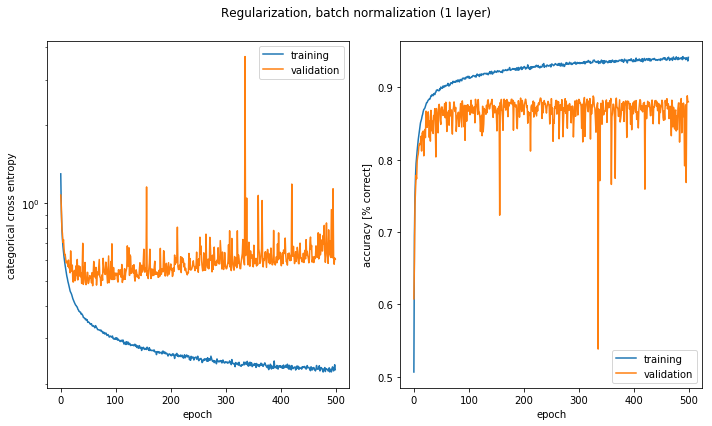

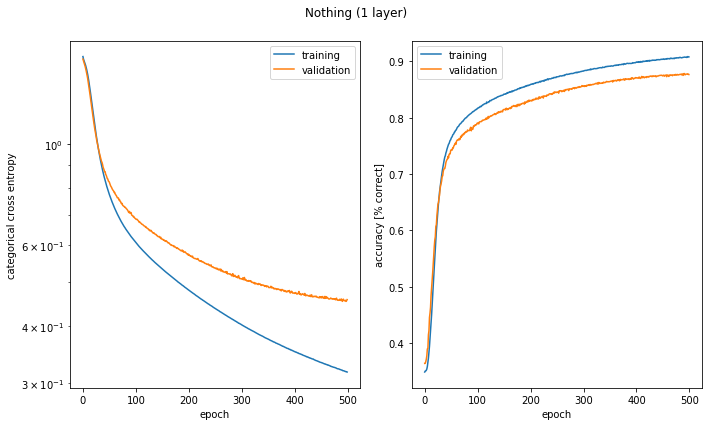

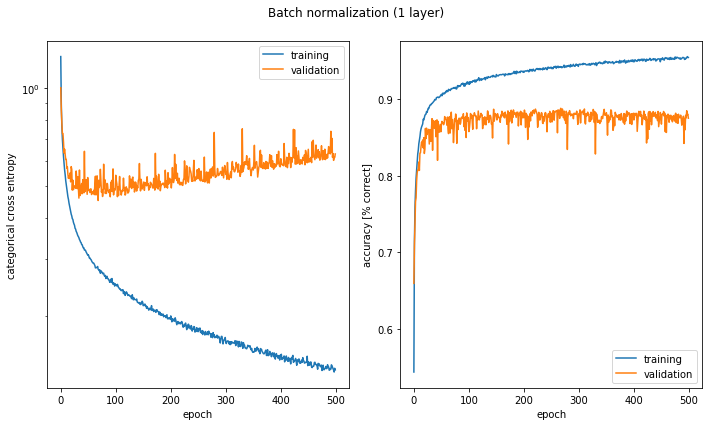

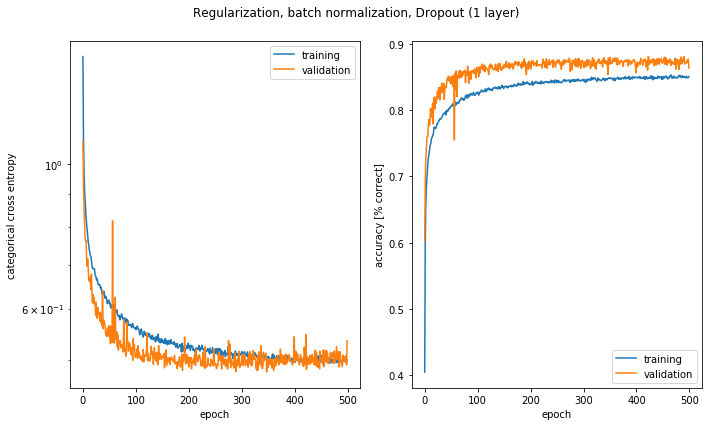

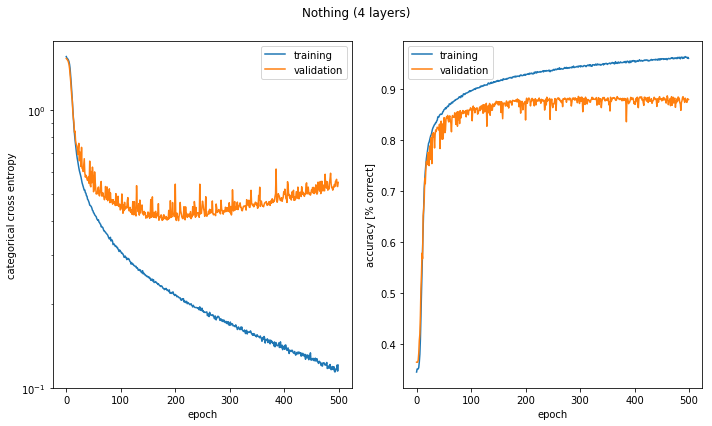

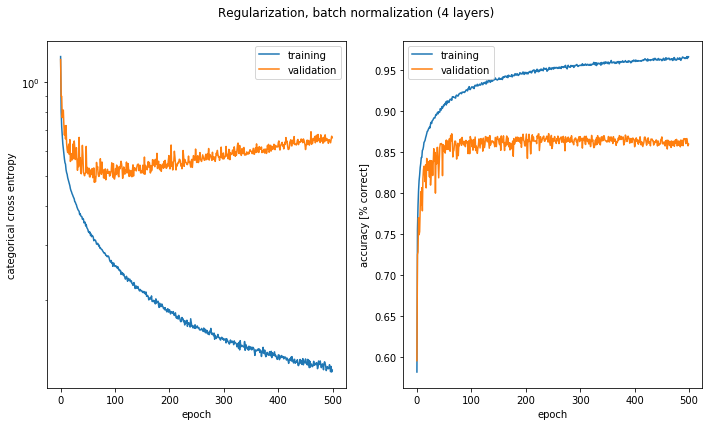

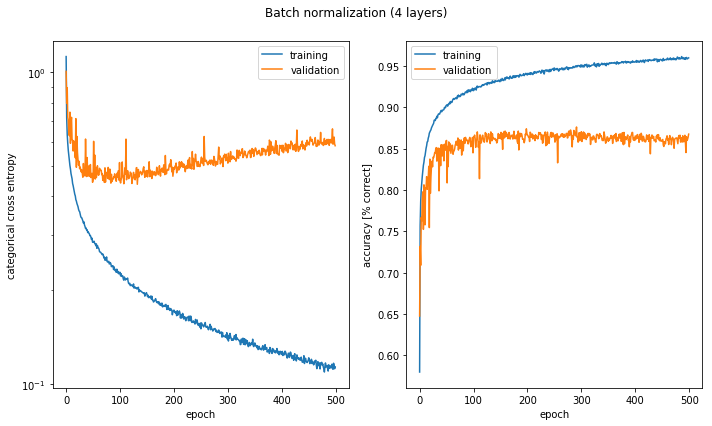

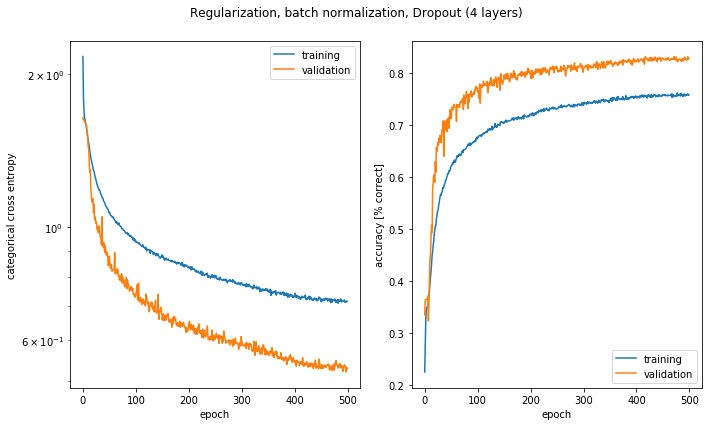

In [17]:
plot_history(h1, "Regularization, batch normalization (1 layer)")
plt.show()

plot_history(h2, "Nothing (1 layer)")
plt.show()

plot_history(h3, "Batch normalization (1 layer)")
plt.show()

plot_history(h4, "Regularization, batch normalization, Dropout (1 layer)")
plt.show()

plot_history(h5, "Nothing (4 layers)")
plt.show()

plot_history(h6, "Regularization, batch normalization (4 layers)")
plt.show()

plot_history(h7, "Batch normalization (4 layers)")
plt.show()

plot_history(h8, "Regularization, batch normalization, Dropout (4 layers)")
plt.show()

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [18]:
x_train_cnn = x_train.reshape(-1,16,16,1)
x_test_cnn = x_test.reshape(-1,16,16,1)

print('x_train shape:', x_train_cnn.shape)
print('x_test shape:', x_test_cnn.shape)
print(x_train_cnn.shape[0], 'train samples')
print(x_test_cnn.shape[0], 'test samples')

input_shape = x_train_cnn.shape
num_classes = 5
batch_size = 128


ex7_model = Sequential()
ex7_model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=(16,16,1)))
ex7_model.add(Conv2D(64, (3, 3), activation='relu'))
ex7_model.add(MaxPooling2D(pool_size=(2, 2)))
ex7_model.add(Conv2D(82, (3, 3), activation='relu'))
ex7_model.add(Dropout(0.5))
ex7_model.add(Flatten())
ex7_model.add(Dense(128, activation='relu'))
ex7_model.add(Dropout(0.5))
ex7_model.add(Dense(num_classes, activation='softmax'))

ex7_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = ex7_model.fit(x_train_cnn, y_train,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=(x_test_cnn, y_test))

score = ex7_model.evaluate(x_test_cnn, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (39523, 16, 16, 1)
x_test shape: (14002, 16, 16, 1)
39523 train samples
14002 test samples
Train on 39523 samples, validate on 14002 samples
Epoch 1/20
39523/39523 [==============================] - 23s 572us/step - loss: 0.9797 - acc: 0.6187 - val_loss: 0.4134 - val_acc: 0.8635
Epoch 2/20
39523/39523 [==============================] - 22s 568us/step - loss: 0.3686 - acc: 0.8787 - val_loss: 0.3128 - val_acc: 0.9027
Epoch 3/20
39523/39523 [==============================] - 23s 578us/step - loss: 0.2918 - acc: 0.9066 - val_loss: 0.2516 - val_acc: 0.9242
Epoch 4/20
39523/39523 [==============================] - 21s 532us/step - loss: 0.2623 - acc: 0.9174 - val_loss: 0.2316 - val_acc: 0.9301
Epoch 5/20
39523/39523 [==============================] - 23s 580us/step - loss: 0.2390 - acc: 0.9237 - val_loss: 0.2133 - val_acc: 0.9336
Epoch 6/20
39523/39523 [==============================] - 25s 629us/step - loss: 0.2230 - acc: 0.9291 - val_loss: 0.2011 - val_acc: 0.9379
Epoch 7/20

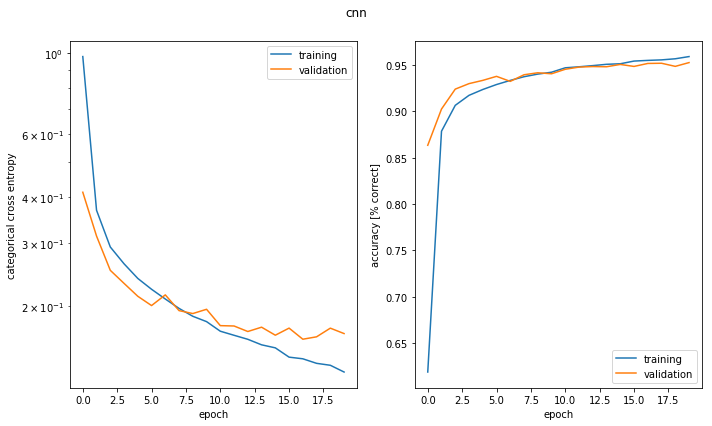

In [20]:
plot_history(history, "cnn")
plt.show()